In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
%matplotlib inline

In [3]:
target_types={6:'Microlensing', 15:'Explosive Type V', 16:'Transits', 42:'Explosive type W', 52:'Explosive Type X', 
                  53:'Long periodic', 62:'Explosive Type Y', 64:'Near Burst', 65:'Flare', 67:'Explosive Type Z',
                  88:'AGN', 90:'SN Type U', 92:'Periodic', 95:'SN Type T'}

In [4]:
train_series = pd.read_csv('../input/training_set.csv')
train_metadata = pd.read_csv('../input/training_set_metadata.csv')

In [5]:
groups = train_series.groupby(['object_id', 'passband'])
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})
flux = groups.apply(
    lambda block: block['flux'].values
).reset_index().rename(columns={0: 'seq'})
err = groups.apply(
    lambda block: block['flux_err'].values
).reset_index().rename(columns={0: 'seq'})
det = groups.apply(
    lambda block: block['detected'].astype(bool).values
).reset_index().rename(columns={0: 'seq'})
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
err_list = err.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
det_list = det.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()

In [6]:
object_list=times.groupby('object_id').apply(lambda x: x['object_id'].unique()[0]).tolist()

In [7]:
colors = ['purple', 'blue', 'green', 'orange', 'red', 'black']

def plot_one_object(obj_id):
        
    for band in range(len(colors)):
        sample = train_series[(train_series['object_id'] == obj_id) & (train_series['passband']==band)]
        plt.errorbar(x=sample['mjd'],y=sample['flux'],yerr=sample['flux_err'],c = colors[band],fmt='o',alpha=0.7)


In [8]:
for t in sorted(train_metadata['target'].unique()):
    print (t,train_metadata[train_metadata['target']== t]['target'].count(),target_types[t],train_metadata[train_metadata['target']== t]['hostgal_specz'].mean())

6 151 Microlensing 0.0
15 495 Explosive Type V 0.24357676767676767
16 924 Transits 0.0
42 1193 Explosive type W 0.22996244761106419
52 183 Explosive Type X 0.22970601092896167
53 30 Long periodic 0.0
62 484 Explosive Type Y 0.19497045454545456
64 102 Near Burst 0.07439803921568627
65 981 Flare 0.0
67 208 Explosive Type Z 0.22544855769230773
88 370 AGN 0.9679970270270275
90 2313 SN Type U 0.3630812797233031
92 239 Periodic 0.0
95 175 SN Type T 1.217438285714286


In [9]:
extragal_target=train_metadata[train_metadata['hostgal_photoz']!=0.0]['target'].unique()
t_type={}
ddf_type={}
wdf_type={}
for t in extragal_target:
    t_type[t] = train_metadata[(train_metadata['target']==t)].index
    ddf_type[t] = train_metadata[(train_metadata['target']==t) & (train_metadata['ddf']==1)].index
    wdf_type[t] = train_metadata[(train_metadata['target']==t) & (train_metadata['ddf']==0)].index
t_colors={15:'skyblue',42:'green',52:'purple',62:'fuchsia',64:'blue',67:'gold',88:'aqua',90:'red',95:'peru'}

In [10]:
t_type

{88: Int64Index([   1,   20,   22,   37,   38,   49,   58,   81,  108,  125,
             ...
             7552, 7568, 7602, 7658, 7669, 7745, 7762, 7801, 7810, 7816],
            dtype='int64', length=370),
 42: Int64Index([   2,    7,   11,   12,   18,   23,   26,   30,   35,   52,
             ...
             7776, 7778, 7781, 7785, 7792, 7793, 7819, 7822, 7831, 7836],
            dtype='int64', length=1193),
 90: Int64Index([   3,    4,    6,    8,   10,   13,   27,   28,   29,   31,
             ...
             7803, 7805, 7808, 7812, 7814, 7817, 7820, 7825, 7829, 7844],
            dtype='int64', length=2313),
 67: Int64Index([  16,   17,  114,  163,  201,  219,  239,  262,  276,  285,
             ...
             7479, 7546, 7637, 7638, 7675, 7708, 7766, 7786, 7811, 7840],
            dtype='int64', length=208),
 95: Int64Index([  19,   54,   82,  129,  184,  203,  240,  432,  444,  455,
             ...
             7358, 7450, 7451, 7462, 7655, 7664, 7684, 7698, 7717, 7790]

## Kernel interpolation with one parameter

In [11]:
# 231 bins in time... 
time_grid=(np.arange(59550,60705,5.))

In [12]:
def fit_kernel_length_only(times_band,flux_band,err_band):
    
    def _kernel_likelihood(length):
        sigma=siguess
        #length=params
        kernel=np.exp(-(np.reshape(times_band,(-1,1)) - times_band)**2/2/length**2)
        np.fill_diagonal(kernel,0)
        sumw=kernel.dot(1./err_band**2) + 1./sigma**2
        pred=kernel.dot(flux_band/err_band**2) / sumw
        chi2 = (pred - flux_band)**2 / ( err_band**2 + 1./sumw )
        # -2 ln likelihood
        logl=np.sum(chi2 + np.log(err_band**2 + 1./sumw))
        return logl
    
    lguess=(np.max(times_band)-np.min(times_band))/len(times_band)
    siguess=np.std(flux_band)
    output=optimize.fmin(_kernel_likelihood,lguess,disp=False,xtol=0.01,full_output=1)
    return (siguess,output[0][0]), output[1]
   

def kernel_predict(params,times_band,flux_band,err_band):
    sigma=params[0]
    length=params[1]
    kernel=np.exp(-(np.reshape(time_grid,(-1,1)) - times_band)**2/2/length**2)
    sumw=kernel.dot(1./err_band**2) + 1./sigma**2
    pred=kernel.dot(flux_band/err_band**2) / sumw
    return pred, np.sqrt(1./sumw)

In [13]:
def make_kernel(tlist,flist,elist,fit_kernel_function=fit_kernel_length_only):
    flux_grid = []
    err_grid = []
    kernel_sigma = []
    kernel_length = []
    kernel_logl=[]
    for iobj,(times_obj,flux_obj,err_obj) in enumerate(zip(tlist,flist,elist)):
        flux_grid_obj=[]
        err_grid_obj=[]
        kernel_sigma_obj = []
        kernel_length_obj = []
        kernel_logl_obj=[]
        if iobj in train_metadata[train_metadata['hostgal_photoz']!=0.0].index:
            for times_band,flux_band,err_band in zip(times_obj,flux_obj,err_obj):
                (sigma,length),logl = fit_kernel_function(times_band,flux_band,err_band)
                k_flux,k_err=kernel_predict((sigma,length),times_band,flux_band,err_band)
                flux_grid_obj.append(k_flux)
                err_grid_obj.append(k_err)
                kernel_sigma_obj.append(sigma)
                kernel_length_obj.append(length)
                kernel_logl_obj.append(logl)
        else:
            kernel_sigma_obj=[0]*6
            kernel_length_obj=[0]*6
            kernel_logl_obj=[0]*6
        flux_grid.append(flux_grid_obj)
        err_grid.append(err_grid_obj)
        kernel_sigma.append(kernel_sigma_obj)
        kernel_length.append(kernel_length_obj)
        kernel_logl.append(kernel_logl_obj)
    return flux_grid,err_grid, kernel_sigma, kernel_length,kernel_logl
        
        
    

In [14]:
colors = ['purple', 'blue', 'green', 'orange', 'red', 'black']
def plot_interpolations(iobj,times_list,flux_list,err_list,flux_grid,err_grid):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
    plt.title(target_types[train_metadata.loc[iobj,'target']]) 
    for band in range(6):
        ax = axes[band // 3, band % 3]
        ax.errorbar(times_list[iobj][band],flux_list[iobj][band],yerr=err_list[iobj][band],color=colors[band],fmt='o')
        ax.plot(time_grid,flux_grid[iobj][band],color=colors[band])
        ax.fill_between(time_grid,flux_grid[iobj][band]-err_grid[iobj][band],
                        flux_grid[iobj][band]+err_grid[iobj][band],alpha=0.3,color=colors[band])
        ax.set_xlabel('MJD')
        ax.set_ylabel('Flux')
    plt.title(target_types[train_metadata.loc[iobj,'target']])    


6.392560656046845 7.689738021763396 191.19034136718196


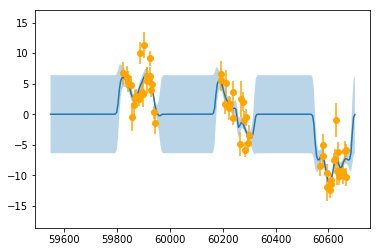

In [15]:
iobj=1
band=3

(sigma,length),logl = fit_kernel_length_only(times_list[iobj][band],flux_list[iobj][band],err_list[iobj][band])
#length=4.0
k_flux,k_err=kernel_predict((sigma,length),times_list[iobj][band],flux_list[iobj][band],err_list[iobj][band])
plt.errorbar(times_list[iobj][band],flux_list[iobj][band],yerr=err_list[iobj][band],color=colors[band],fmt='o')
plt.plot(time_grid,k_flux)
plt.fill_between(time_grid,k_flux-k_err,k_flux+k_err,alpha=0.3)
plt.ylim(np.min(flux_list[iobj][band]*1.5,0),np.max(flux_list[iobj][band]*1.5,0))
#plt.xlim(60100,60300)
print (sigma,length,logl)

In [16]:

klonly_flux_grid,klonly_err_grid,klonly_sigma,klonly_length,klonly_logl = make_kernel(
    times_list,flux_list,err_list,fit_kernel_function=fit_kernel_length_only)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


(60000, 60250)

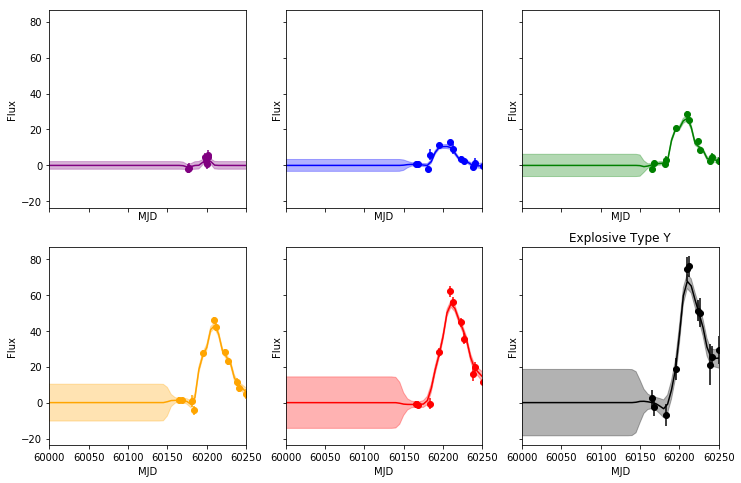

In [17]:

plot_interpolations(300,times_list,flux_list,err_list,klonly_flux_grid,klonly_err_grid)
#plt.ylim(-50,200)
plt.xlim(60000,60250)


## Class 64 metrics

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


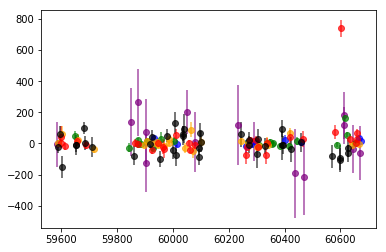

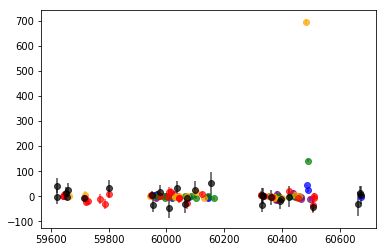

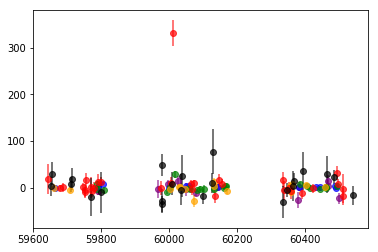

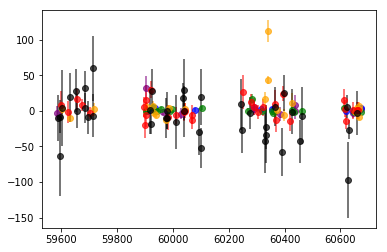

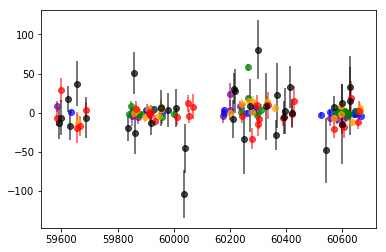

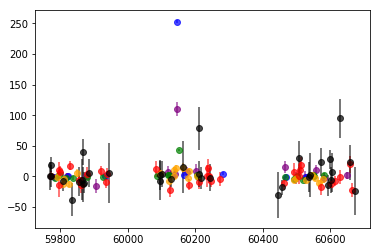

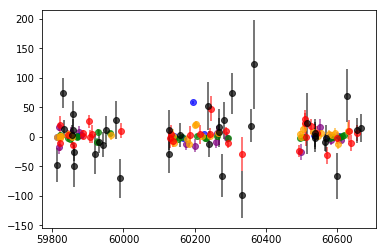

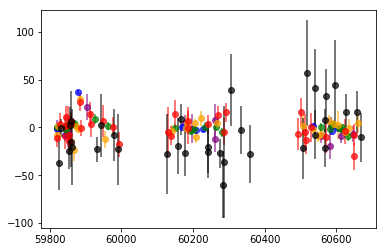

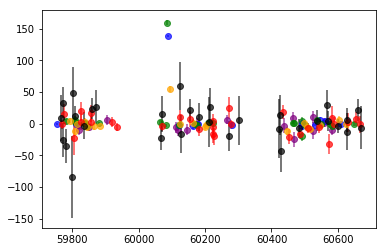

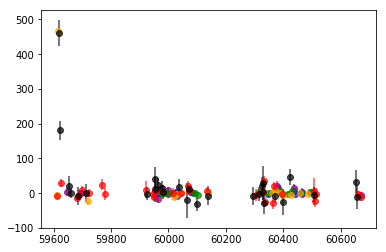

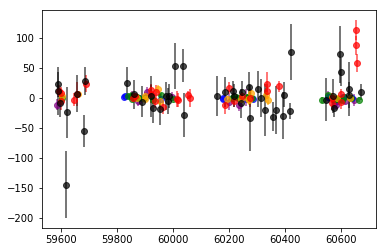

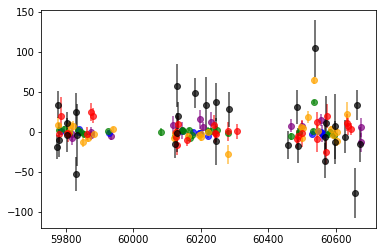

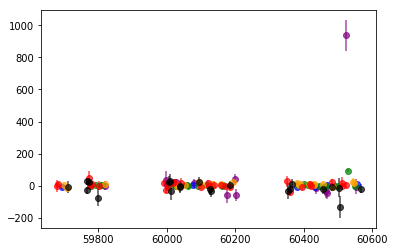

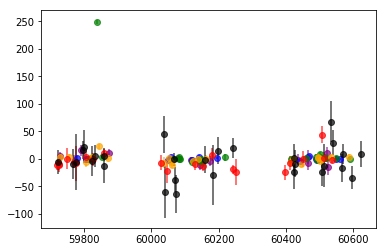

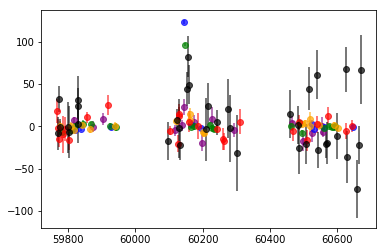

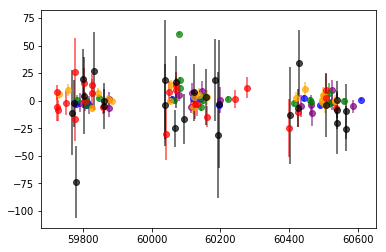

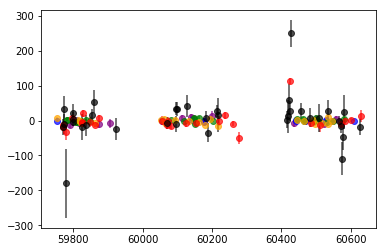

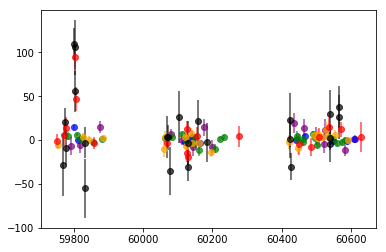

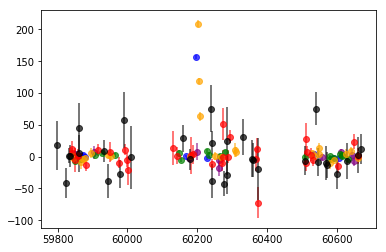

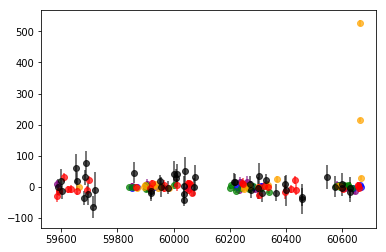

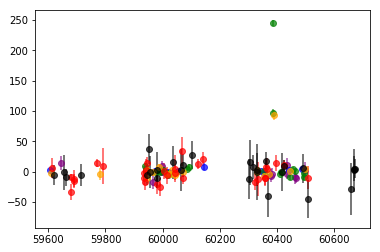

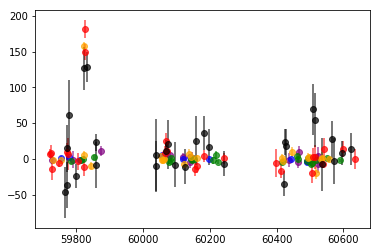

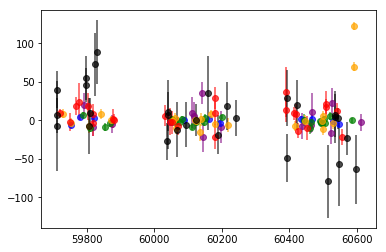

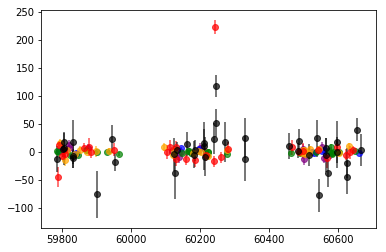

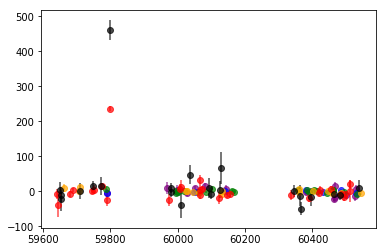

In [18]:
for iobj in train_metadata[(train_metadata['target']==64) & (train_metadata['ddf']==0)]['object_id'][:25]:
    plt.figure()
    plot_one_object(iobj)

In [19]:
def make_metrics_65_88():
    maxsigma_list = np.zeros(len(train_metadata))
    fluxmax_list = np.zeros(len(train_metadata))
    fracplus3sigma_list= np.zeros(len(train_metadata))
    fracminus3sigma_list= np.zeros(len(train_metadata))
    minsigma_list = np.zeros(len(train_metadata))
    min3sigma_list= np.zeros(len(train_metadata))
    for i in train_metadata[(train_metadata['hostgal_photoz']>0.0)].index:
        #print i
        maxsigma=np.zeros(6)
        minsigma=np.zeros(6)
        fluxmax = np.zeros(6)
        nbplus3sigma=0
        nbminus3sigma=0
        nbdata=0
        for b in range(6):
            deltamed = flux_list[i][b] - np.median(flux_list[i][b])
            fluxmax[b] = np.max( deltamed )
            maxsigma[b] = np.max(deltamed / err_list[i][b] )
            minsigma[b] = np.min( deltamed / err_list[i][b] )
            nbplus3sigma += np.sum( ( deltamed/ err_list[i][b] )>3)
            nbminus3sigma += np.sum( (deltamed/ err_list[i][b] )<-3)
            nbdata += len(flux_list[i][b])
        fluxmax_list[i] = np.max(fluxmax)
        maxsigma_list[i] = np.max(maxsigma)
        minsigma_list[i] = np.max(minsigma)
        fracplus3sigma_list[i] = nbplus3sigma*1./(nbdata)
        fracminus3sigma_list[i] = nbminus3sigma*1./(nbdata)
    return maxsigma_list, fracplus3sigma_list, fluxmax_list, minsigma_list, fracminus3sigma_list

In [20]:
maxsigma,fracplus3sigma,fluxmax,minsigma, fracminus = make_metrics_65_88()

In [21]:
def plot_features_types(plotx,ploty, limx=None,limy=None,subtypes=extragal_target):
    if limx or limy:
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        axes0=axes[0]
    else:
        fig, axes0 = plt.subplots(1, 3, figsize=(12, 4))
        
    for t in subtypes:
        ax = axes0[0]
        ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
        ax.set_title("All")
        ax = axes0[1]
        ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
        ax.set_title("DDF")
        ax = axes0[2]
        ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)
        ax.set_title("WDF")
                
        if limx or limy:
            ax = axes[1,0]
            ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
            ax = axes[1,1]
            ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
            ax = axes[1,2]
            ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)
            for i in range(3):
                ax = axes[1,i]
                if limx:
                    ax.set_xlim(limx)
                if limy:
                    ax.set_ylim(limy)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


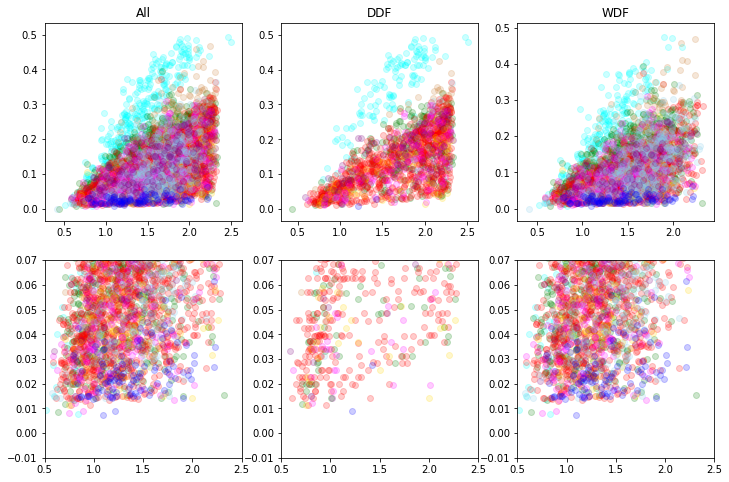

In [22]:
plot_features_types(np.log10(maxsigma),fracplus3sigma,limx=(0.5,2.5),limy=(-0.01,0.07))

### Plots for AGN

In [23]:
fracminus

array([0.        , 0.22285714, 0.        , ..., 0.        , 0.        ,
       0.        ])

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


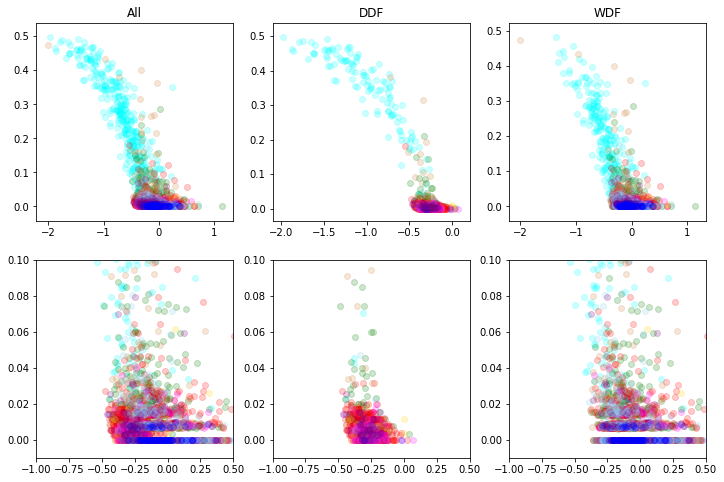

In [24]:
plot_features_types(-np.log10(-minsigma),fracminus,limx=(-1,0.5),limy=(-0.01,0.1))

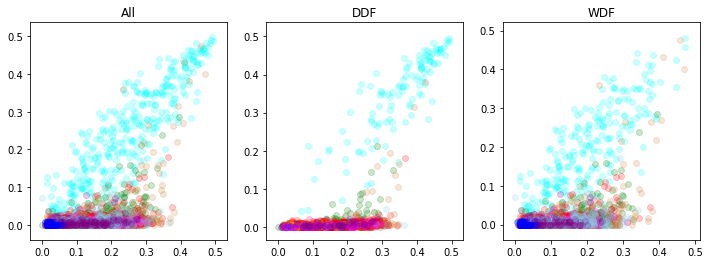

In [25]:
plot_features_types(fracplus3sigma,fracminus)#,limx=(-1,0.5),limy=(-0.01,0.1))

## Redshift studies

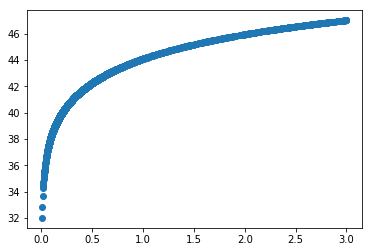

In [26]:
# distmod is in fact computed on hostgal_photoz
plt.plot(train_metadata['hostgal_photoz'],train_metadata['distmod'],'o')


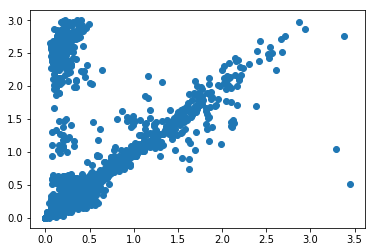

In [27]:
# Hey, photo-z are ugly !
plt.plot(train_metadata['hostgal_specz'],train_metadata['hostgal_photoz'],'o')

In [28]:
from scipy.integrate import quad

H0 = 70.05 # km.s-1 Mpc-1
Om = 0.30
Olambda = 1 - Om

def integrand(z):
    return (1./np.sqrt(Om*(1+z)**3 + Olambda) )

def dl(z):
    dh = 300000. / H0 * 1.e6
    return dh * (1+z) * quad(integrand,0.,z)[0]

def distmod(z):
    return 5 * np.log10(dl(z) / 10.)

(-0.002, 0.002)

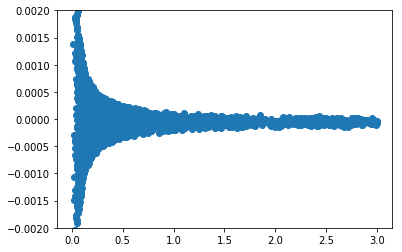

In [29]:
plt.plot(train_metadata['hostgal_photoz'],train_metadata['hostgal_photoz'].apply(distmod) - train_metadata['distmod'],'o')
plt.ylim((-0.002,0.002))

### Fluxmax as a function of z per class...

In [30]:
absmagmax=-2.5 * np.log10(fluxmax) - train_metadata['hostgal_specz'].apply(distmod)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [31]:
fluxscale = train_metadata['hostgal_specz'].apply(dl)**2 / 1.e17

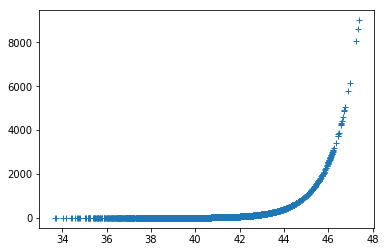

In [32]:
plt.plot(train_metadata['hostgal_specz'].apply(distmod),fluxscale,'+')

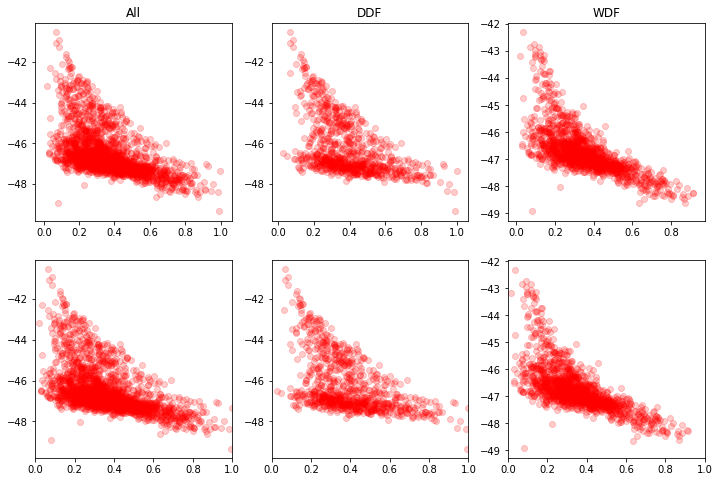

In [33]:
plot_features_types(train_metadata['hostgal_specz'],absmagmax,limx=(0,1),subtypes=[90])#,limy=(-0.01,0.1))


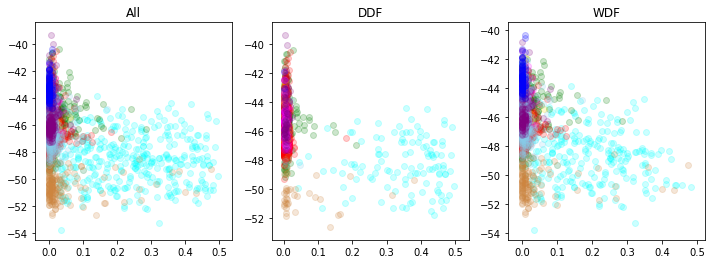

In [34]:
plot_features_types(fracminus,absmagmax)#,limx=(0,1),subtypes=[90])#,limy=(-0.01,0.1))


## Class 88 (AGN)

In [35]:
klonly_sigmapadded=[np.max(([0]*6,k),axis=0) for k in klonly_sigma ]
klonly_lengthpadded=[np.abs(k) for k in klonly_length ]


In [36]:
logmean=np.log(np.mean(klonly_sigmapadded,axis=1))
np.isfinite(np.log(np.mean(klonly_sigmapadded,axis=1)))

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


array([False,  True,  True, ..., False, False, False])

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


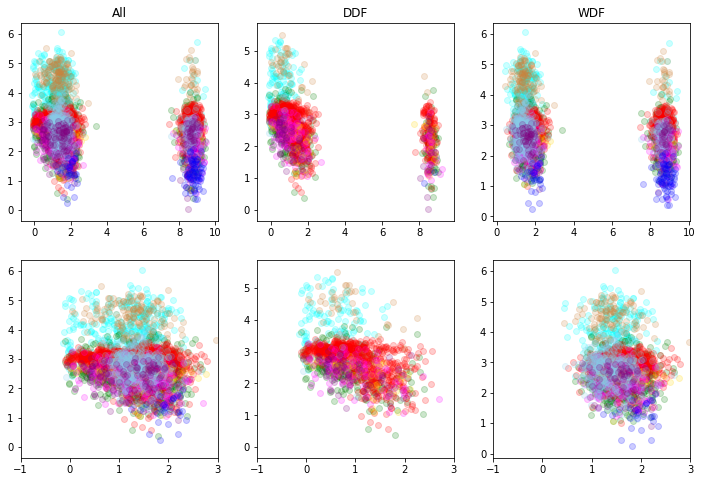

In [37]:
plot_features_types(np.log10(np.mean(klonly_lengthpadded,axis=1)),np.log10(np.mean(klonly_sigmapadded,axis=1)*fluxscale),limx=(-1,3))#,subtypes=[90])#,limy=(-0.01,0.1))

